
# Neutrino Finder


In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import pandas as pd
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

In [2]:
##   HYPERPARAMETERS    ##

VARS =  14           # number of columns in each event, after one hot encoding
MAX_SIZE = 15        # number of rows after padding = maximum number of particles in an event in the data set

cudnn.benchmark = True

# Fraction of data to be used for training
f = 0.9

# Batch size during training
batch_size = 32

# Number of training epochs
num_epochs = 50

# Hidden layer dimensions
nh1 = 256
nh2 = 128

# Optimizer parameters
lr = 0.001
beta1 = 0.9
beta2 = 0.999

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

In [3]:
##  DATA HANDLING   ##

sig = pd.read_csv('sig.csv', sep=',', header=None)
bkg = pd.read_csv('bkg.csv', sep=',', header=None)
X = pd.concat([sig, bkg], axis=0).values


y = np.zeros((sig.shape[0] + bkg.shape[0],))
y[:sig.shape[0]] = 1

dataset = TensorDataset(torch.from_numpy(X), torch.from_numpy(y)) 

gen = torch.Generator().manual_seed(42)
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [f, 1-f], gen)
print('Training set size = %6d \nTest set size = %6d' % (len(train_dataset), len(test_dataset))) 

trainloader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
testloader  = DataLoader(test_dataset, shuffle=True, batch_size=batch_size)

Training set size = 900001 
Test set size =  99999


In [4]:
##  DEFINE NEURAL NETWORK   ##

class NuNet(nn.Module): 
    def __init__(self, nh1, nh2):
        super(NuNet, self).__init__()

        self.nh1 = nh1
        self.nh2 = nh2
        self.main = nn.Sequential(
            nn.Linear(VARS*MAX_SIZE, self.nh1),
            nn.ReLU(),
            nn.Linear(self.nh1, self.nh2),
            nn.ReLU(),
            nn.Linear(self.nh2, 1),
            nn.Sigmoid()
        )

    def forward(self, input):
        output = self.main(input)
        return output


In [5]:
##  INSTANTIATE NEURAL NETWORK   ##

net = NuNet(nh1, nh2).to(device)
optimizer = torch.optim.Adam(net.parameters(), lr= lr, betas=(beta1, beta2))
loss_fn = nn.BCELoss()

In [ ]:
##  TRAINING  ##

loss_list = []
num_batches = len(trainloader)
net.train()

print("Starting Training Loop...")

# For each epoch
for epoch in range(num_epochs):

    epoch_loss = 0
    
    # For each batch in the dataloader
    for i, data in enumerate(trainloader):

        # Forward pass and loss calculation
        X_batch, y_batch = data
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        X_batch, y_batch = X_batch.to(torch.float32), torch.squeeze(y_batch.to(torch.float32))
        yhat = torch.squeeze(net(X_batch))
        loss = loss_fn(yhat, y_batch)
        
        # Backward pass and optimizer step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Output training stats
        epoch_loss += loss.item()
        if i % 250 == 0:
            print('[%d/%d][%d/%d] \t Avg. Epoch Loss: %.4f' % (epoch, num_epochs, i, len(trainloader), epoch_loss/(i+1)))
    
    epoch_loss = epoch_loss/num_batches

    # Save Losses 
    loss_list.append(epoch_loss)

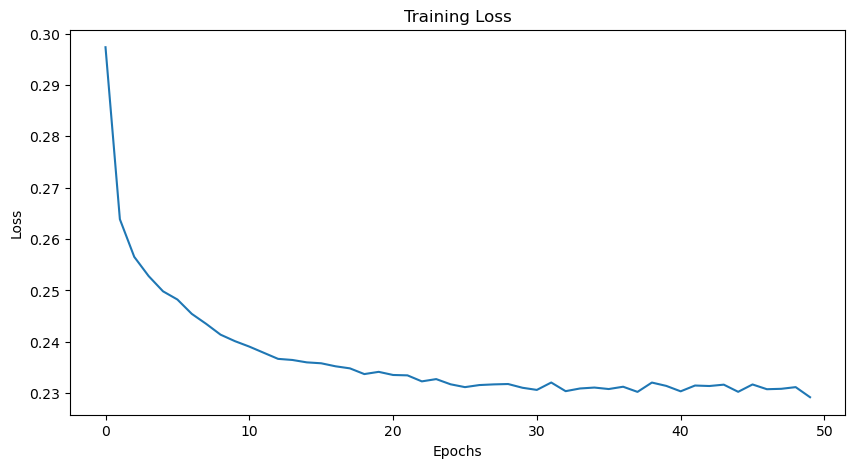

In [7]:
##  LOSS PLOT  ##

plt.figure(figsize=(10,5))
plt.title("Training Loss")
plt.plot(loss_list)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

In [8]:
# TESTING #

test_y = torch.empty(size=(len(test_dataset),))
test_y_pred = torch.empty(size=(len(test_dataset),))
loc = 0

for i, data in enumerate(testloader):
    l= len(data[0])
    test_X_i, test_y_i = data
    test_X_i = test_X_i.to(torch.float32).to(device)

    with torch.no_grad():
        net.eval()
        test_y_pred_i = torch.squeeze(net(test_X_i))
    
    test_y[loc:loc+l] = test_y_i
    test_y_pred[loc:loc+l] = test_y_pred_i
    loc += l

Text(0.5, 1.0, 'Receiver Operating Characteristic')

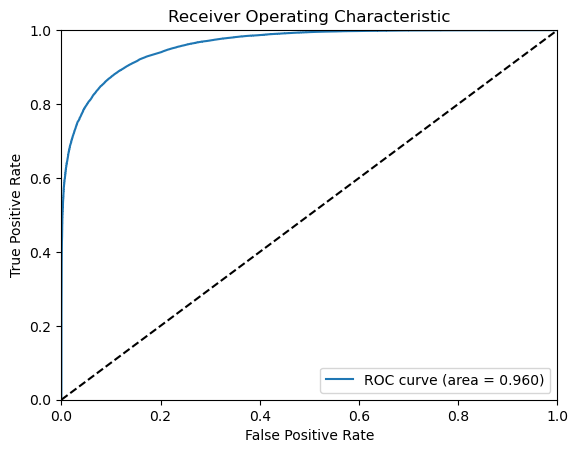

In [9]:
##  ROC CURVE  ##

fpr, tpr, thresholds = roc_curve(test_y, test_y_pred.cpu())
roc_auc = auc(fpr, tpr)

# Plot 
plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.legend(loc = 'lower right')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')